In [1]:
import matplotlib.pyplot as plt

import numpy as np
import qcodes as qc
from time import time
from qcodes.instrument_drivers.Keysight.M9203A import M9203A
from qcodes.tests.instrument_mocks import DummyInstrument
#from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A

Connect to the device:

In [2]:
dig = M9203A('dig', "PXI20::0::0::INSTR")
dac = DummyInstrument(name="dac", gates=['ch1', 'ch2'])  # The DAC voltage source

# Finally, the instruments should be bound to a Station. Only instruments bound to the Station get recorded in the
# measurement metadata, so your metadata is blind to any instrument not in the Station.
station = qc.Station(dig)

Zoidberg2 Digitizer Specs:
M9203A-LX2 Digital Processing Unit FPGA LX195T
M9203A-F05 Bandwidth, 650 MHz maximum
M9203A-DGT Digitizer Firmware
M9203A-M02 Memory, 256MB, 64M Samples / ch
M9203A-SR2 Maximum Sampling Rate, 1.6 GS/s per channel
M9203A-CH2 Two Channels


In [3]:
# Let's have a look at the available parameters 
dig.print_readable_snapshot(update=True)

dig:
	parameter               value
--------------------------------------------------------------------------------
IDN                      :	{'vendor': None, 'model': 'dig', 'serial': None, '...
IQ_data_averaged         :	None (('V', 'V', 's', 's'))
IQ_data_raw              :	None (('V', 'V', 's', 's'))
NumRecordsPerAcquisition :	1 
NumberOfAcquisitions     :	1 
NumberOfAverages         :	1 
RecordSize               :	1024 (pts)
SampleRate               :	1e+08 (Hz)
TimeOut                  :	1 (s)
TriggerLevel             :	0 (V)
TriggerType              :	Internal1 
dig_Channel1:
	parameter value
--------------------------------------------------------------------------------
offset :	0 (V)
range  :	2 (V)
dig_Channel2:
	parameter value
--------------------------------------------------------------------------------
offset :	0 (V)
range  :	2 (V)


A list of all available parameters can be found in the following manner:

In [4]:
pars = np.sort(list(dig.parameters.keys()))
for param in pars:
    if type(dig.parameters[param]).__name__ == 'IQArray_raw':
        print(param, ': ', dig.parameters[param].labels)
    elif type(dig.parameters[param]).__name__ == 'IQArray_averaged':
        print(param, ': ', dig.parameters[param].labels)
    else:
        print(param, ': ', dig.parameters[param].label)

IDN :  IDN
IQ_data_averaged :  ('I_out_av', 'Q_out_av', 'I_time', 'Q_time')
IQ_data_raw :  ('I_out', 'Q_out', 'I_time', 'Q_time')
NumRecordsPerAcquisition :  Number of Records
NumberOfAcquisitions :  Number of Acquisitions
NumberOfAverages :  Number of Averages
RecordSize :  Number of Samples
SampleRate :  Digitizer Sample Rate
TimeOut :  Digitizer TimeOut
TriggerLevel :  Digitizer Trigger Level
TriggerType :  Digitizer Trigger Type


# Configure the acquisition trigger

In [5]:
dig.TriggerType('External1') # set trigger type
dig.TriggerLevel(0.5)        # set trigger level
dig.TimeOut(60)
print('Timeout value:', dig.TimeOut())                # read timeout value

Timeout value: 60


Check channel settings:

In [6]:
print('The location of the center of the range: ',dig.Channel1.offset())
print('The absolute value of the input range the digitizer can acquire for the channel: ',dig.Channel1.range())

The location of the center of the range:  0.0
The absolute value of the input range the digitizer can acquire for the channel:  2.0


# Configure the acquisition

In [7]:
dig.NumRecordsPerAcquisition(100)      # Specifies the number of records in the acquisition.
dig.RecordSize(10e4)                   # Specifies the number of samples in each record.
dig.NumberOfAcquisitions(10)          # Specifies the number of acquistions

# Specify the sample rate in samples per second. Should be 1.6e9/(2**n) (where n=0,...,5)
dig.SampleRate(1.6e9/(2**5))

print('Total number of records/averages (NumRecordsPerAcquisition x NumberOfAcquisitions): ',dig.NumberOfAverages())

Record Size is set to  100000
Sample Rate is set to 5.000000e+07 Hz
Total number of records/averages (NumRecordsPerAcquisition x NumberOfAcquisitions):  1000


Calibrate the Instrument

In [8]:
dig.SelfCalibrate()

# Perform single/multi-record acquisition (TSR)

In [9]:
data = dig.IQ_data_averaged()

Fetching data...
Number of Acquisitions:  10
Number of Records Per Acquisition:  100
**Number of Averages (= NumberOfAcquisitions x NumberOfRecordsPerAcquisition):  1000 **
get() of "IQArray_averaged" was executed in 22.12457251548767 s
If running QCoDes Measure() or Loop() function: Waiting for QCoDes to write the data to a file.


In [10]:
start_time = time()
data = qc.Measure(dig.IQ_data_raw).run()
print('Time elapsed (s):',time()-start_time)

Fetching data...
Number of Acquisitions:  1
Number of Records Per Acquisition:  1
get() of "IQArray_raw" was executed in 0.05520129203796387 s
If running QCoDes Measure() or Loop() function: Waiting for QCoDes to write the data to a file.
DataSet:
   location = 'data/2018-08-01/#003_{name}_16-09-46'
   <Type>   | <array_id>         | <array.name>   | <array.shape>
   Setpoint | TimeQ_raw_npts_set | TimeQ_raw_npts | (100000,)
   Measured | dig_I_data         | I_data         | (1, 100000)
   Measured | dig_Q_data         | Q_data         | (1, 100000)
   Measured | dig_I_time         | I_time         | (100000,)
   Measured | dig_Q_time         | Q_time         | (100000,)
acquired at 2018-08-01 16:09:50
Time elapsed (s): 4.064016342163086


In [10]:
start_time = time()
data = qc.Measure(dig.IQ_data_averaged).run()
print('Time elapsed (s):',time()-start_time)

Fetching data...
Number of Acquisitions:  10
Number of Records Per Acquisition:  100
**Number of Averages (= NumberOfAcquisitions x NumberOfRecordsPerAcquisition):  1000 **
get() of "IQArray_averaged" was executed in 21.456258058547974 s
If running QCoDes Measure() or Loop() function: Waiting for QCoDes to write the data to a file.
DataSet:
   location = 'data/2018-08-01/#005_{name}_16-17-59'
   <Type>   | <array_id>     | <array.name> | <array.shape>
   Setpoint | TimeQ_npts_set | TimeQ_npts   | (100000,)
   Measured | dig_I_data_av  | I_data_av    | (100000,)
   Measured | dig_Q_data_av  | Q_data_av    | (100000,)
   Measured | dig_I_time     | I_time       | (100000,)
   Measured | dig_Q_time     | Q_time       | (100000,)
acquired at 2018-08-01 16:18:24
Time elapsed (s): 24.96566915512085


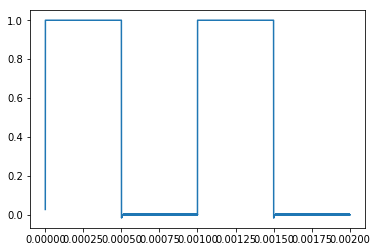

In [11]:
plt.plot(data.dig_I_time,data.dig_I_data_av)
plt.show()

In [10]:
loop = qc.Loop(dac.ch1.sweep(0, 0.5, 0.1), delay=0.001).each(dig.IQ_data)
data = loop.get_data_set(name='test')
plot_1d = qc.QtPlot()  # create a plot
plot_1d.add(data.dig_I_data[0])  # add a graph to the plot
_ = loop.with_bg_task(plot_1d.update, plot_1d.save).run()  # run the loop
plot_1d

In [15]:
dig.disconnect()

The insrument instance is closed.
